In [1]:
from transformers import AutoModelForMaskedLM
from transformers import AutoTokenizer
import torch
from datasets import load_dataset
from transformers import DataCollatorForLanguageModeling
from transformers import TrainingArguments
from transformers import Trainer
import math
from torch.utils.data import DataLoader
from transformers import default_data_collator
from torch.optim import AdamW
from accelerate import Accelerator
from transformers import get_scheduler
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import preprocessing
import pickle
import pandas as pd

/home/laurinemeier/anaconda3/envs/swerick/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
def insert_random_mask(batch,data_collator):
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    masked_inputs = data_collator(features)
    # Create a new "masked" column for each column in the dataset
    return {"masked_" + k: v.numpy() for k, v in masked_inputs.items()}

In [4]:
model_checkpoint = "KBLab/bert-base-swedish-cased"
model = preprocessing.create_model_MLM(model_checkpoint)

Some weights of the model checkpoint at KBLab/bert-base-swedish-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
tokenizer =preprocessing.create_tokenizer(model_checkpoint)

In [11]:
#datasest
data_files = {"train": "swerick_data_random_train.pkl", "test": "swerick_data_random_test.pkl"}
swerick_dataset = load_dataset("pandas",data_files=data_files)
print(swerick_dataset)


DatasetDict({
    train: Dataset({
        features: ['protocole', 'texte'],
        num_rows: 12399
    })
    test: Dataset({
        features: ['protocole', 'texte'],
        num_rows: 2673
    })
})


In [7]:
tokenized_datasets =preprocessing.tokenize_dataset(swerick_dataset,tokenizer)

tokenized_datasets


Map:   0%|          | 0/12399 [00:00<?, ? examples/s]

KeyboardInterrupt: 

In [ ]:
chunk_size = 128

In [ ]:
with open("token_dataset.pkl","wb") as f:
    pickle.dump(tokenized_datasets,f)

In [ ]:
tokenized_datasets=tokenized_datasets.remove_columns("protocole")


In [ ]:
tokenized_datasets["train"]

In [6]:
lm_datasets = preprocessing.grouping_dataset(tokenized_datasets,chunk_size)
lm_datasets

NameError: name 'tokenized_datasets' is not defined

In [ ]:
with open("lm_dataset.pkl","wb") as f:
    pickle.dump(lm_datasets,f)

In [6]:
with open("lm_dataset.pkl","rb") as f:
    lm_datasets= pickle.load(f)

In [12]:
data_valid={"valid":"swerick_data_random_valid.pkl"}
valid_dataset = load_dataset("pandas",data_files=data_valid) 



In [10]:
valid_dataset =preprocessing.tokenize_dataset(valid_dataset,tokenizer)

Map:   0%|          | 0/2570 [00:09<?, ? examples/s]


KeyboardInterrupt: 

In [ ]:
valid_dataset=preprocessing.grouping_dataset(valid_dataset,chunk_size)

valid_dataset

In [ ]:
with open("valid_dataset.pkl","wb") as f:
     pickle.dump(valid_dataset,f)

In [7]:
with open("valid_dataset.pkl","rb") as f:
    valid_dataset= pickle.load(f)

valid_dataset

DatasetDict({
    valid: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 762794
    })
})

In [8]:

valid_dataset=valid_dataset.remove_columns(["word_ids","token_type_ids"])

In [9]:
data_collator = preprocessing.data_collector_masking(tokenizer,0.15)

trial with a manual implementation

In [10]:
print(lm_datasets["train"])

lm_dataset_bis = lm_datasets.remove_columns(["word_ids","token_type_ids"])

print(lm_dataset_bis["test"])
eval_dataset = preprocessing.create_deterministic_eval_dataset(lm_dataset_bis["test"],data_collator)
valid_dataset=preprocessing.create_deterministic_eval_dataset(valid_dataset["valid"],data_collator)

print(eval_dataset)

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids', 'labels'],
    num_rows: 3663965
})
Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 800106
})
Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 800106
})


In [11]:
batch_size = 64
train_dataloader = preprocessing.create_dataloader(lm_dataset_bis["train"],batch_size,data_collator)
def to_device(batch):
    return {key: value.to(device) for key, value in batch.items()}

print("ok")
eval_dataloader = preprocessing.create_dataloader(eval_dataset,batch_size,default_data_collator)
valid_dataloader=preprocessing.create_dataloader(valid_dataset,batch_size,default_data_collator)
print("ok")

#for batch in train_dataloader:
    #batch = to_device(batch)

#for batch in eval_dataloader:
    #batch = to_device(batch)




print(eval_dataloader.dataset)

ok
ok
Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 800106
})


In [51]:
from transformers import PreTrainedTokenizerFast

swerick_tokenizer= PreTrainedTokenizerFast(
    tokenizer_file="/home/laurinemeier/swerick/pretraining_from_scratch/tokenizer_swerick.json",
    unk_token="[UNK]",
    pad_token="[PAD]",
    cls_token="[CLS]",
    sep_token="[SEP]",
    mask_token="[MASK]"
)

In [20]:
import transformers
config = transformers.BertConfig.from_pretrained("/home/laurinemeier/swerick/checkpoint-105178")
mosaicBert = AutoModelForMaskedLM.from_pretrained("/home/laurinemeier/swerick/checkpoint-105178",config=config,trust_remote_code=True)

/home/laurinemeier/.cache/huggingface/modules/transformers_modules/checkpoint-105178/bert_layers.py:177: UserWarning: Unable to import Triton; defaulting MosaicBERT attention implementation to pytorch (this will reduce throughput when using this model).
  warnings.warn(


In [65]:
from transformers import pipeline
pipe = pipeline(task="fill-mask", model=mosaicBert, tokenizer=swerick_tokenizer)
pipe("Hey [MASK]")

[{'score': 0.051451172679662704,
  'token': 2550,
  'token_str': 'Johansson',
  'sequence': 'Hey Johansson'},
 {'score': 0.036675550043582916,
  'token': 7826,
  'token_str': 'Ekman',
  'sequence': 'Hey Ekman'},
 {'score': 0.024931393563747406,
  'token': 10683,
  'token_str': 'Gustafson',
  'sequence': 'Hey Gustafson'},
 {'score': 0.020839007571339607,
  'token': 1458,
  'token_str': 'Stockholm',
  'sequence': 'Hey Stockholm'},
 {'score': 0.013345717452466488,
  'token': 34491,
  'token_str': 'Vällingby',
  'sequence': 'Hey Vällingby'}]

In [ ]:
model_long=AutoModelForMaskedLM.from_pretrained("./finetuning_hugging-finetuned-imdb/checkpoint-259384")
model_long=model_long.to("cpu")

In [ ]:
model=AutoModelForMaskedLM.from_pretrained("./test_model")
model=model.to("cpu")

In [18]:
model_hugging_face = AutoModelForMaskedLM.from_pretrained("finetuning/finetuning_hugging_whitespace-finetuned-imdb/checkpoint-5725000")
model_hugging_face=model_hugging_face.to(device)

In [21]:
model_hugging_face2 = AutoModelForMaskedLM.from_pretrained("finetuning/finetuning_hugging_whitespace-finetuned-imdb/checkpoint-5782250")
model_hugging_face2=model_hugging_face2.to(device)

In [ ]:
model_kb=AutoModelForMaskedLM.from_pretrained(model_checkpoint)
model_kb=model_kb.to(device)

Some weights of the model checkpoint at KBLab/bert-base-swedish-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [14]:
valid_data = preprocessing.tokenize_dataset(valid_dataset,swerick_tokenizer)
valid_data = preprocessing.grouping_dataset(valid_data,128)

Map: 100%|██████████| 2570/2570 [20:27<00:00,  2.09 examples/s]


In [15]:
valid_data

DatasetDict({
    valid: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 706758
    })
})

In [ ]:
with open("valid_scratch.pkl","wb") as f :
    pickle.dump(valid_data,f)

In [ ]:
with open("valid_scratch.pkl","wb") as f :
    valid_data = pickle.load(f)

In [23]:
data_collector =preprocessing.data_collector_masking(tokenizer,0.15)
valid_data = valid_data.remove_columns(["word_ids","token_type_ids"])
valid_scratch_loader =preprocessing.create_deterministic_eval_dataset(valid_data["valid"],data_collator)
valid_scratch_loader =preprocessing.create_dataloader(valid_scratch_loader,64,default_data_collator)

In [16]:
from evaluation.evaluation import evaluation_task

#evaluation_task(model_kb,valid_scratch_loader,"finetuning_hugging_whitespace-finetuned-imdb/checkpoint-4179250")
evaluation_task(model_hugging_face,valid_dataloader,"finetuning_hugging_whitespace-finetuned-imdb/checkpoint-4179250")

Trainer evaluation....
Manual perplexity...
 Perplexity: 2.5609514375507376
Accuracy...
Accuracy: 0.77724601843933


In [17]:
print(lm_datasets)

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 3663965
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 800106
    })
})


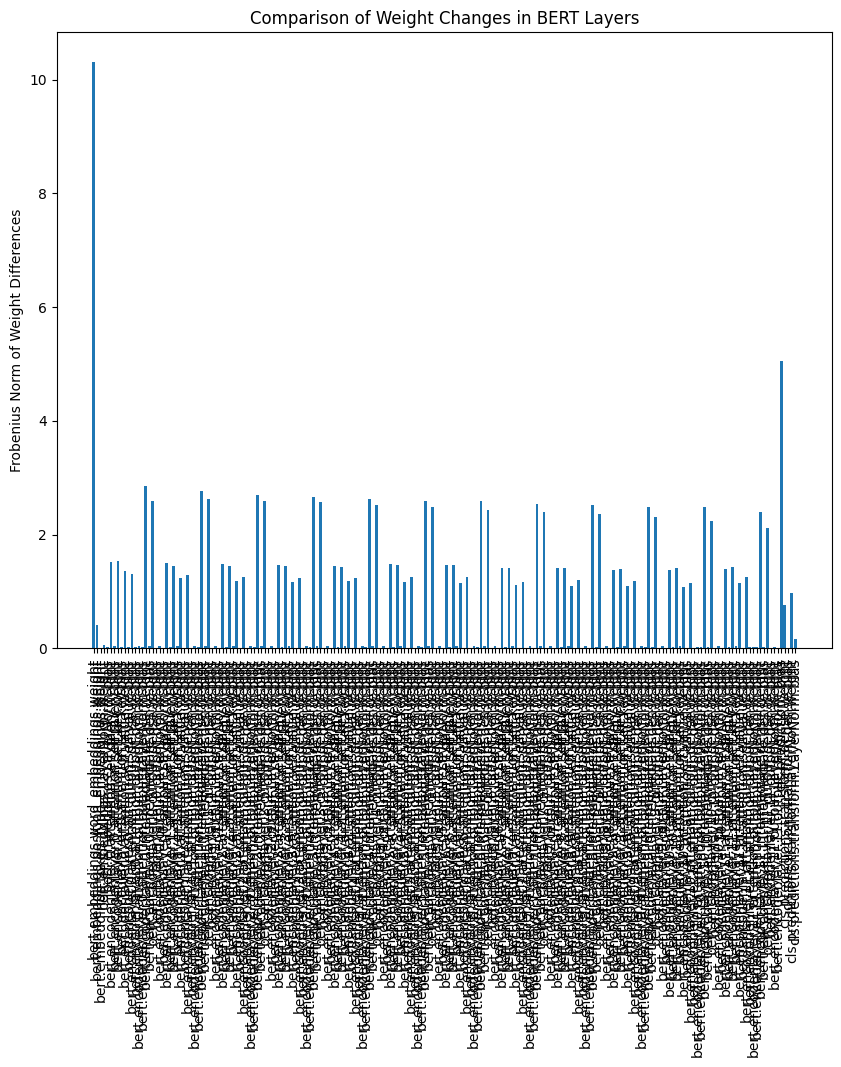

In [22]:
# Comparaison of weights for different models
import matplotlib.pyplot as plt
import numpy as np

def get_model_weights(model):
    weights = {}
    for name, param in model.named_parameters():
        weights[name] = param.detach().cpu().numpy()
    return weights


weights_kb = get_model_weights(model_hugging_face2)
weights_finetuned = get_model_weights(model_hugging_face)

weight_diffs = {}
for key in weights_kb.keys():
    weight_diffs[key] = weights_finetuned[key] - weights_kb[key]
    if np.linalg.norm(weight_diffs[key]) > 100:
        print(key)
        print(np.linalg.norm(weight_diffs[key]))
    


norms = [np.linalg.norm(weight_diffs[key]) for key in weight_diffs.keys()]

plt.figure(figsize=(10, 8))
plt.bar(range(len(norms)), norms, tick_label=list(weight_diffs.keys()))
plt.xticks(rotation=90)
plt.ylabel('Frobenius Norm of Weight Differences')
plt.title('Comparison of Weight Changes in BERT Layers')
plt.show()   



In [52]:
print(weights_finetuned.keys())

dict_keys(['bert.embeddings.word_embeddings.weight', 'bert.embeddings.position_embeddings.weight', 'bert.embeddings.token_type_embeddings.weight', 'bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.self.query.weight', 'bert.encoder.layer.0.attention.self.query.bias', 'bert.encoder.layer.0.attention.self.key.weight', 'bert.encoder.layer.0.attention.self.key.bias', 'bert.encoder.layer.0.attention.self.value.weight', 'bert.encoder.layer.0.attention.self.value.bias', 'bert.encoder.layer.0.attention.output.dense.weight', 'bert.encoder.layer.0.attention.output.dense.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.intermediate.dense.weight', 'bert.encoder.layer.0.intermediate.dense.bias', 'bert.encoder.layer.0.output.dense.weight', 'bert.encoder.layer.0.output.dense.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.

['checkpoint-343500', 'checkpoint-400750', 'checkpoint-458000', 'checkpoint-515250', 'checkpoint-572500', 'checkpoint-629750', 'checkpoint-687000', 'checkpoint-744250', 'checkpoint-801500', 'checkpoint-858750', 'checkpoint-916000', 'checkpoint-973250', 'checkpoint-1030500', 'checkpoint-1087750', 'checkpoint-1145000', 'checkpoint-1202250', 'checkpoint-1259500', 'checkpoint-1316750', 'checkpoint-1374000', 'checkpoint-1431250', 'checkpoint-1488500', 'checkpoint-1545750', 'checkpoint-1603000', 'checkpoint-1660250', 'checkpoint-1717500', 'checkpoint-1774750', 'checkpoint-1832000', 'checkpoint-1889250', 'checkpoint-1946500', 'checkpoint-2003750', 'checkpoint-2061000', 'checkpoint-2118250', 'checkpoint-2175500', 'checkpoint-2232750', 'checkpoint-2290000', 'checkpoint-2347250', 'checkpoint-2404500', 'checkpoint-2461750', 'checkpoint-2519000', 'checkpoint-2576250', 'checkpoint-2633500', 'checkpoint-2690750', 'checkpoint-2748000', 'checkpoint-2805250', 'checkpoint-2862500', 'checkpoint-2919750',

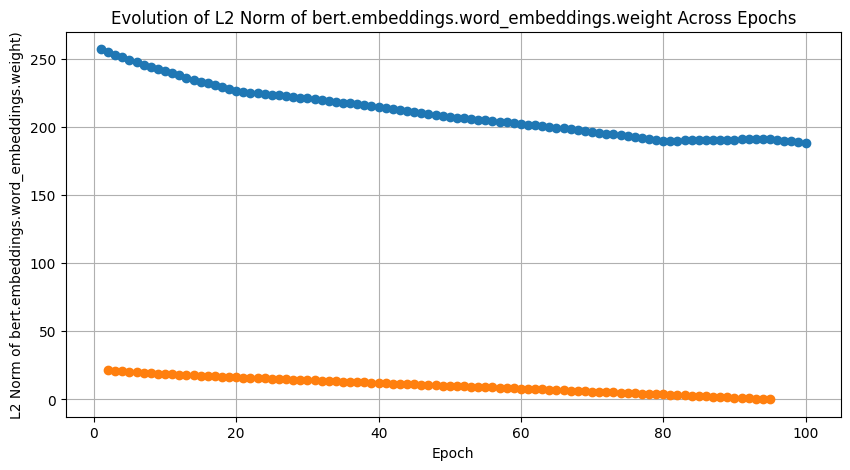

In [46]:
# Evolution of the weight of cls.predictions.bias through finetuning
import os
import re
import numpy  as np

# Chemin vers le dossier contenant vos checkpoints
checkpoint_directory = 'finetuning/finetuning_hugging_whitespace-finetuned-imdb'
checkpoint_files = os.listdir(checkpoint_directory)

checkpoint_files.sort(key=lambda x: int(re.search(r'checkpoint-(\d+)', x).group(1)))
print(checkpoint_files)
# Liste pour stocker les normes des poids
bias_norms = []
drift=[]
bias_weight=model_kb.bert.embeddings.word_embeddings.weight.detach().cpu().numpy()
print(np.linalg.norm(bias_weight))
# Chargement de chaque checkpoint et calcul de la norme de cls.predictions.bias
for checkpoint in checkpoint_files:
    model = AutoModelForMaskedLM.from_pretrained("finetuning/finetuning_hugging_whitespace-finetuned-imdb/" + checkpoint)
    ref_weight = bias_weight
    bias_weight = model.bert.embeddings.word_embeddings.weight.detach().cpu().numpy()
    norm = np.linalg.norm(bias_weight)
    bias_norms.append(norm)
    drift.append(np.linalg.norm(bias_weight - ref_weight))
    

# Affichage des normes
epochs = list(range(1, len(bias_norms) + 1))
plt.figure(figsize=(10, 5))
plt.plot(epochs, bias_norms, marker='o')
plt.plot(epochs[1:95], drift[1:95], marker='o')
plt.xlabel('Epoch')
plt.ylabel('L2 Norm of bert.embeddings.word_embeddings.weight)')
plt.title('Evolution of L2 Norm of bert.embeddings.word_embeddings.weight Across Epochs')
plt.grid(True)
plt.show()

In [143]:
from collections import Counter
import torch

# Initialisation d'un compteur pour les IDs des tokens
token_frequencies = Counter()

# Parcourir chaque exemple dans le dataset
for example in lm_datasets["train"]:
    # Mettre à jour le compteur avec les IDs des tokens de chaque exemple
    token_frequencies.update(example['input_ids'])

# Maintenant, token_frequencies contient les IDs des tokens et leurs fréquences

# Trouver les tokens les plus fréquents
# Vous pouvez ajuster le nombre 'n' pour obtenir le nombre de tokens les plus fréquents que vous souhaitez
n = 10  # Par exemple, pour obtenir les 10 tokens les plus fréquents
most_common_tokens = token_frequencies.most_common(n)

# Extraire les IDs des tokens et leurs fréquences
most_common_ids, most_common_freqs = zip(*most_common_tokens)

# Conversion des IDs les plus fréquents en tensor pour d'autres utilisations
most_common_ids_tensor = torch.tensor(most_common_ids)

# Affichage des tokens les plus fréquents et leurs fréquences
print("Les IDs des tokens les plus fréquents et leurs fréquences :")
for token_id, freq in zip(most_common_ids, most_common_freqs):
    print(f"Token ID: {token_id}, Fréquence: {freq}")

In [131]:
#change in embedding $
model_hugging_face = AutoModelForMaskedLM.from_pretrained("finetuning/finetuning_hugging_whitespace-finetuned-imdb/checkpoint-5725000")
model_hugging_face=model_hugging_face.to(device)
ref_weight = model_kb.bert.embeddings.word_embeddings.weight.detach()[unique_token_ids]
bias_weight = model_hugging_face.bert.embeddings.word_embeddings.weight.detach()[unique_token_ids]
embedding_changes = torch.norm(bias_weight - ref_weight, dim=1)

unk_index = tokenizer.convert_tokens_to_ids('[UNK]')
pad_index =  tokenizer.convert_tokens_to_ids('[PAD]')
print(pad_index)
print(embedding_changes[unk_index])
print(embedding_changes[pad_index])
values, top_indices = torch.topk(embedding_changes, 25)

# Convert indices to tokens
top_words = [tokenizer.convert_ids_to_tokens(idx.item()) for idx in top_indices]
print(values)
# Print the results
print("Top 25 words with the most changed embeddings vectors:")
for word in top_words:
    print(word)


0
tensor(0.9825, device='cuda:0')
tensor(1.0108, device='cuda:0')
tensor([1.5969, 1.5810, 1.5689, 1.5599, 1.5550, 1.5538, 1.5507, 1.5499, 1.5499,
        1.5450, 1.5448, 1.5421, 1.5419, 1.5418, 1.5416, 1.5392, 1.5355, 1.5253,
        1.5243, 1.5211, 1.5209, 1.5186, 1.5186, 1.5182, 1.5182],
       device='cuda:0')
Top 25 words with the most changed embeddings vectors:
Brow
mikroskop
kommunalrådet
##IKT
##maten
##KTION
##äderna
fordran
kvinnlig
Sil
biljetten
efterrätt
Malaga
seklets
##AND
##ättande
##ledar
Michigan
##elgen
rekommendera
##inan
##amera
frå
Break
##smiddagen


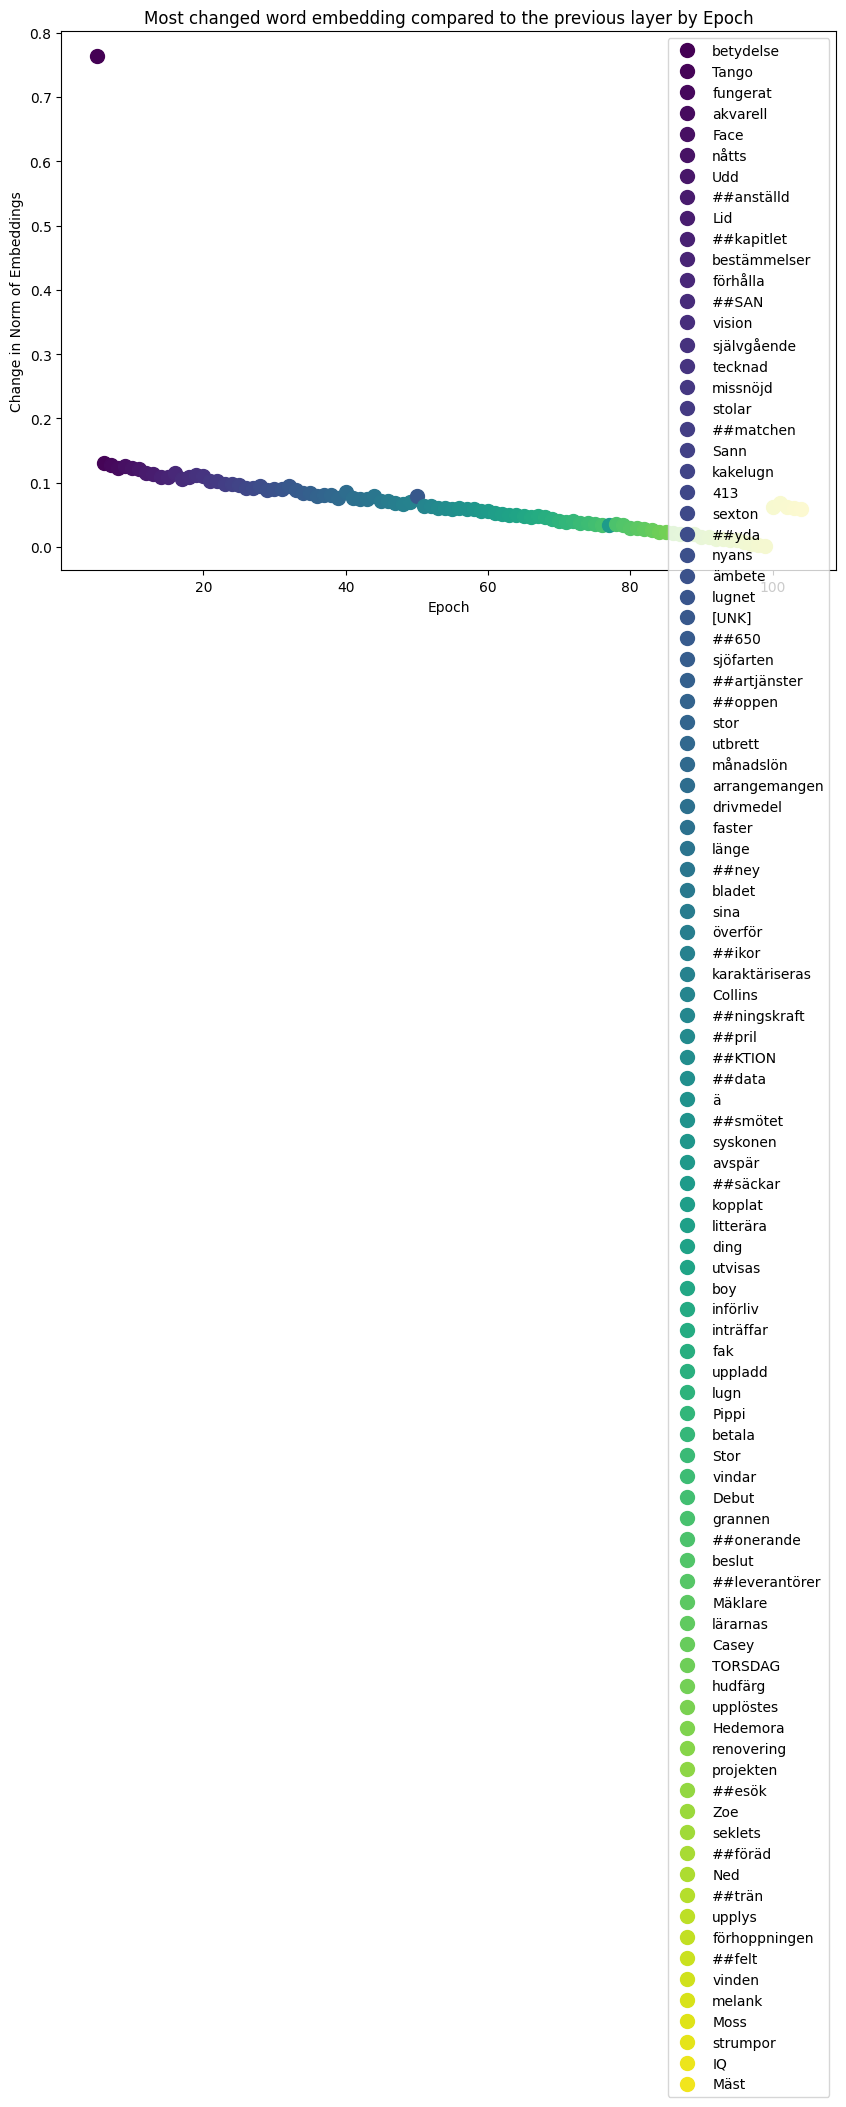

In [142]:
checkpoint_directory = 'finetuning/finetuning_hugging_whitespace-finetuned-imdb'
checkpoint_files = os.listdir(checkpoint_directory)

checkpoint_files.sort(key=lambda x: int(re.search(r'checkpoint-(\d+)', x).group(1)))
epoch_data = {}
word_color = {}
total_frequencies = {}
embeddings = model_kb.bert.embeddings.word_embeddings.weight.detach()[unique_token_ids]
colors = plt.cm.viridis(np.linspace(0, 1, 100))
# Training loop
epoch=4
for checkpoint in checkpoint_files:
    epoch +=1
    model = AutoModelForMaskedLM.from_pretrained("finetuning/finetuning_hugging_whitespace-finetuned-imdb/" + checkpoint)
    model=model.to(device)
    initial_embeddings = embeddings
    embeddings = model.bert.embeddings.word_embeddings.weight.detach()[unique_token_ids]

    embedding_changes = torch.norm(embeddings - initial_embeddings, dim=1)
    
    # Get the top 5 changes
    _, top_indices = torch.topk(embedding_changes, 1)
    top_words = [tokenizer.convert_ids_to_tokens(idx.item()) for idx in top_indices]
    top_changes = embedding_changes[top_indices].tolist()
    for word in top_words:
            if word not in word_color:
                word_color[word] = colors[len(word_color) % len(colors)]
            if word not in total_frequencies :
                total_frequencies[word] =1
            if word  in total_frequencies :
                total_frequencies[word] +=1
        
    # Store data
    epoch_data[epoch] = list(zip(top_words, top_changes))

# Plotting
fig, ax = plt.subplots(figsize=(10, 7))
already_labeled = set()
for epoch in epoch_data:
    words, changes = zip(*epoch_data[epoch])
    if words[0] not in already_labeled:
        ax.plot([epoch] * 1, changes, marker='o', linestyle='', markersize=10,color=word_color[words[0]],label=words[0])
        already_labeled.add(words[0])
    else : 
        ax.plot([epoch] * 1, changes, marker='o', linestyle='', markersize=10,color=word_color[words[0]])

ax.set_xlabel('Epoch')
ax.set_ylabel('Change in Norm of Embeddings')
ax.set_title('Most changed word embedding compared to the previous layer by Epoch')
ax.legend()
plt.show()

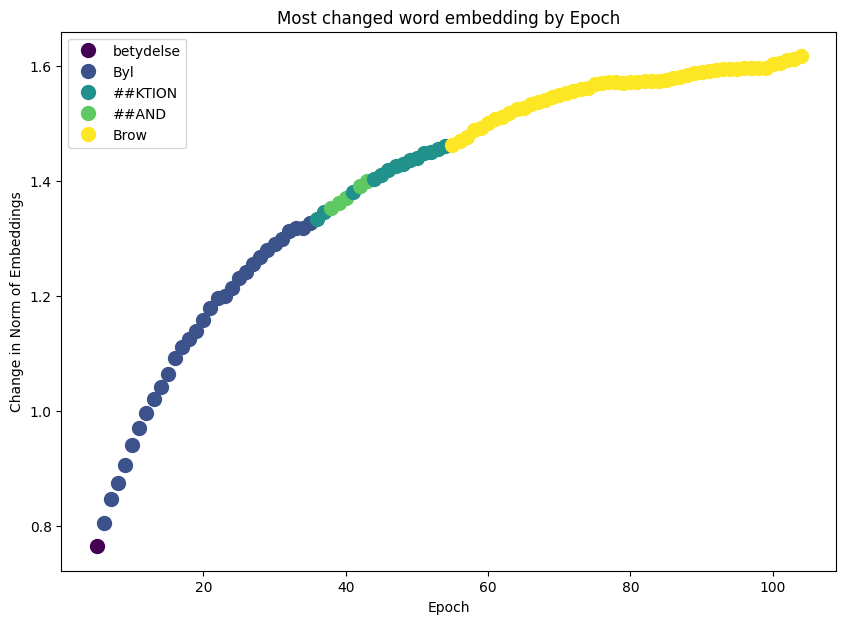

In [141]:
fig, ax = plt.subplots(figsize=(10, 7))
already_labeled = set()
for epoch in epoch_data:
    words, changes = zip(*epoch_data[epoch])
    if words[0] not in already_labeled:
        ax.plot([epoch] * 1, changes, marker='o', linestyle='', markersize=10,color=word_color[words[0]],label=words[0])
        already_labeled.add(words[0])
    else : 
        ax.plot([epoch] * 1, changes, marker='o', linestyle='', markersize=10,color=word_color[words[0]])

ax.set_xlabel('Epoch')
ax.set_ylabel('Change in Norm of Embeddings')
ax.set_title('Most changed word embedding by Epoch')
ax.legend()
plt.show()

In [91]:
total_frequencies

{'[PAD]': 2,
 '##€': 2,
 'läsaren': 2,
 'sopt': 2,
 'Sarajevo': 2,
 '##bearbetning': 2,
 'seglare': 2,
 'tillbaks': 2,
 '##ink': 2,
 'minimala': 2,
 'Jones': 2,
 'Janeiro': 2,
 'diagram': 2,
 'Pontus': 2,
 '##randt': 2,
 '##stidningen': 2,
 'Aur': 2,
 '##ämman': 2,
 'Tru': 2,
 'Wiv': 2,
 '##hotellet': 2,
 'Warner': 2,
 'förbl': 2,
 'cellen': 2,
 'Pojken': 2,
 'Bash': 2,
 'Materialet': 2,
 '[CLS]': 3,
 'Tendens': 2,
 '##övningen': 2,
 'hemligstäm': 2,
 '##röv': 2,
 'Han': 2,
 '##yen': 2,
 '##ygn': 2,
 'Brink': 2,
 'kommunalrådet': 2,
 'LÅNG': 2,
 'kap': 2,
 'dvs': 2,
 'vitvaror': 2,
 'milj': 2,
 'Låg': 2,
 'delegaterna': 2,
 '##brända': 2,
 '##uh': 2,
 'Lausanne': 2,
 'resp': 2,
 'LENN': 2,
 'Föraren': 2,
 'ex': 2,
 '##lip': 2,
 'belönas': 2,
 'utställnings': 2,
 '##YM': 3,
 'fotografi': 2,
 'Pot': 2,
 '##påsar': 2,
 '##säng': 2,
 '##kling': 2,
 '##gicks': 2,
 'Ana': 2,
 'ETT': 2,
 'RING': 2,
 'OO': 2,
 'Knutsson': 2,
 'anal': 2,
 'föd': 2,
 'leker': 2,
 'Gymnastik': 2,
 'Museum': 2,
 '

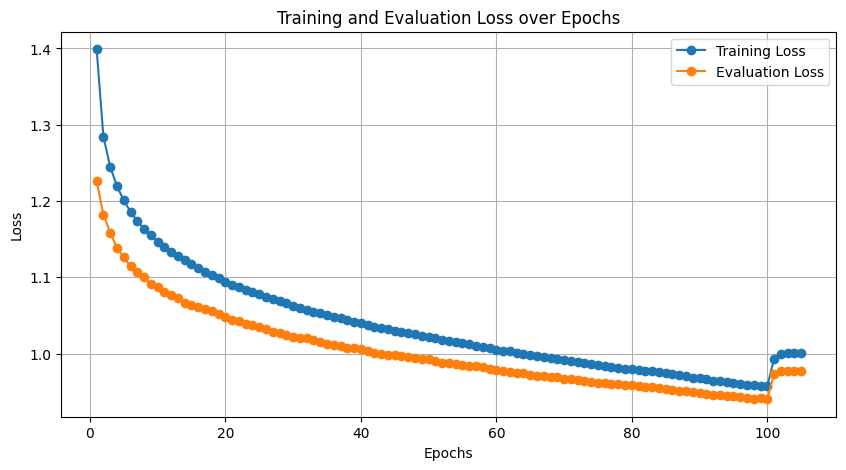

In [14]:
import json
import matplotlib.pyplot as plt

# Charger les données à partir du fichier JSON
with open("/home/laurinemeier/swerick/finetuning/finetuning_hugging_whitespace-finetuned-imdb/checkpoint-6011250/trainer_state.json", 'r') as file:
    data = json.load(file)

train_loss = []
eval_loss = []
epoch_train = []
epoch_test=[]

for entry in data['log_history']:
    if 'loss' in entry:
        train_loss.append(entry['loss'])
        epoch_train.append((entry['epoch']))
    elif 'eval_loss' in entry:
        eval_loss.append(entry['eval_loss'])
        epoch_test.append((entry['epoch']))

plt.figure(figsize=(10, 5))
plt.plot(epoch_train, train_loss, label='Training Loss', marker='o')
plt.plot(epoch_test, eval_loss, label='Evaluation Loss', marker='o')
plt.title('Training and Evaluation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
pad_token_id= tokenizer.pad_token_id
sep_token_id = tokenizer.sep_token_id

In [45]:
def evaluate_model_token(model,dataloader):
    model.eval()
    correct_pred=[]
    incorrect_pred=[]

    for batch in dataloader:
        batch = {key: value.to(device) for key, value in batch.items()} 
        with torch.no_grad():
            outputs=model(**batch)
        predictions=torch.argmax(outputs.logits,dim=-1)
        indices_tokens_masked = torch.nonzero(batch["labels"] != -100, as_tuple=False)
        correct_indices=[]
        incorrect_indices=[]
        for id,label in enumerate(batch["labels"][indices_tokens_masked[:, 0], indices_tokens_masked[:, 1]]):
            if label.item() == predictions[indices_tokens_masked[:, 0], indices_tokens_masked[:, 1]][id]:
                correct_indices.append(id)
            else :
                incorrect_indices.append(id)
        correct_pred.extend(batch['labels'][indices_tokens_masked[:, 0], indices_tokens_masked[:, 1]][correct_indices])
        incorrect_pred.extend(batch['labels'][indices_tokens_masked[:, 0], indices_tokens_masked[:, 1]][incorrect_indices])

    return correct_pred,incorrect_pred

In [39]:
hugging_face_correct,hugging_face_incorrect = evaluate_model_token(model_hugging_face,valid_dataloader)

In [44]:
hugging_face_incorrect_unique = list(set(hugging_face_incorrect))
hugging_face_incorrect_unique


['+',
 '6',
 '«',
 '?',
 'J',
 ',',
 'å',
 'y',
 'ë',
 '$',
 'E',
 'k',
 'U',
 'á',
 "'",
 'Y',
 'f',
 'w',
 '>',
 'm',
 'G',
 '_',
 '2',
 '&',
 'O',
 'n',
 'i',
 'ö',
 'ä',
 'I',
 '£',
 ':',
 '-',
 '.',
 'd',
 'D',
 '*',
 'V',
 '[',
 ']',
 'ç',
 'A',
 'Q',
 '!',
 'l',
 'K',
 'é',
 'h',
 'q',
 'à',
 'b',
 'T',
 'P',
 'c',
 'N',
 '8',
 'g',
 'ü',
 '§',
 '%',
 'L',
 'Z',
 '=',
 'r',
 '4',
 'a',
 '"',
 '#',
 '—',
 'ã',
 ';',
 '1',
 'W',
 'S',
 'É',
 'M',
 'H',
 'R',
 ')',
 'j',
 'F',
 'Ö',
 'Ä',
 'z',
 'ø',
 '|',
 'Å',
 '€',
 '(',
 'è',
 'x',
 '»',
 'B',
 's',
 '0',
 'v',
 'Ó',
 't',
 '5',
 '<',
 'ó',
 ' ',
 'X',
 'e',
 'u',
 '9',
 '3',
 'p',
 'o',
 'C',
 '/',
 '7']

In [46]:
hugging_correct,hugging_incorrect=evaluate_model_token(model_hugging_face,valid_dataloader)

In [53]:
base_correct,base_incorrect=evaluate_model_token(model_kb,valid_dataloader)

In [54]:
from collections import Counter
def decoding_text(list):
    counter = Counter(list)

    # Trier les éléments par leur fréquence décroissante
    sorted_numbers = sorted(counter.items(), key=lambda x: x[1], reverse=True)

    # Extraire les chiffres triés
    unique_sorted_numbers = [num for num, _ in sorted_numbers]

    decoded_texts = []
    for tensor in unique_sorted_numbers:
        decoded_text = tokenizer.decode(tensor.item())
        decoded_texts.append(decoded_text)
    return decoded_texts

In [55]:
decoded_base_correct = decoding_text(base_correct)
decoded_hugging_correct = decoding_text(hugging_correct)

In [61]:
print(len(decoded_base_correct)/(len(decoded_base_correct)+len(base_incorrect)))
print(len(decoded_hugging_correct)/(len(decoded_hugging_correct)+len(hugging_incorrect)))

0.5899161482519455
0.7792149671790606


In [59]:
good_tokens = list(set(decoded_hugging_correct)-set(decoded_base_correct))
print(len(good_tokens))
good_tokens

2078


['flät',
 '##oarer',
 'FAST',
 '##tain',
 'köttbullar',
 'Stadens',
 '##omter',
 'gled',
 'Smart',
 'Längd',
 '##vita',
 'lättad',
 'Up',
 'sankt',
 '##smaskin',
 '##etecken',
 'Eget',
 '##stjärnor',
 '##icers',
 '##bero',
 '##IER',
 '##alom',
 '##frusna',
 '##butik',
 'invester',
 'avsiktligt',
 '##ANN',
 'Europat',
 'Måndag',
 'vandringen',
 'that',
 'Örgryte',
 '##ändskt',
 'Alex',
 'nybyggt',
 '##växel',
 '##aton',
 'Burton',
 '##YK',
 '##ugget',
 '##artan',
 'östern',
 'Globen',
 'Mood',
 '##ward',
 'avveck',
 '##ales',
 '##avd',
 '##såsen',
 '##miral',
 'grytan',
 'vänskapen',
 '##harmon',
 '##ssäsongen',
 '##embl',
 'Raf',
 'Stein',
 'avhandlingen',
 'uppn',
 'musikdirektör',
 '##ografier',
 'trampade',
 '##less',
 'Cirk',
 '##igan',
 '##127',
 '##oplan',
 'Teresa',
 '##ipa',
 'skotten',
 'sun',
 'mästar',
 '##sutställningen',
 'Emilia',
 'Österb',
 '##ävlan',
 '##skiv',
 '668',
 'uppen',
 '##merna',
 'gamm',
 '##rukna',
 '##lekar',
 '##gnost',
 '##oning',
 '786',
 '##provinsen'

In [41]:
max_length=128

In [46]:
def insert_special_masking(batch,i):
    word_ids=batch["word_ids"]
 
    masked_input_id=batch["input_ids"].copy()
    attention_mask=batch["attention_mask"].copy()
 
    labels=[[-100]*max_length]*len(batch["labels"])
    for z in range(len(masked_input_id)):
        if batch["input_ids"][z][i] ==tokenizer.pad_token_id or batch["input_ids"][z][i] ==tokenizer.sep_token_id:
            continue
        
        labels[z][i]=batch["input_ids"][z][i]
        masked_input_id[z][i]=tokenizer.mask_token_id
  
        
        word=tokenizer.decode(batch["input_ids"][z][i])
   
        future_token=[j for j,_ in enumerate(word_ids[z]) if word_ids[z][j]==word_ids[z][i] and j>i]

        for j in future_token:
            labels[z][j]=batch["input_ids"][z][j]
    
            masked_input_id[z][j]=tokenizer.mask_token_id
           

        masked_input_id[z]=np.array(masked_input_id[z])
        attention_mask[z]=np.array(attention_mask[z])
        labels[z]=np.array(labels[z])
   
    output_dict = {"input_ids": masked_input_id, "attention_mask": attention_mask, "labels": labels}
    
    return {k: v for k, v in output_dict.items()}

In [34]:
def insert_special_masking_bis(batch, i):
    word_ids = batch["word_ids"]
    masked_input_id = batch["input_ids"].copy()
    attention_mask = batch["attention_mask"].copy()
    
    labels = np.full_like(masked_input_id, -100)
    
    for z, seq in enumerate(masked_input_id):
        if seq[i] == tokenizer.pad_token_id or seq[i] == tokenizer.sep_token_id:
            continue
        
        labels[z, i] = seq[i]
        masked_input_id[z][i] = tokenizer.mask_token_id
        future_token = [j for j, _ in enumerate(word_ids[z]) if word_ids[z][j] == word_ids[z][i] and j > i]
        
        for j in future_token:
            labels[z][j] = batch["input_ids"][z][j]
            masked_input_id[z][j] = tokenizer.mask_token_id
    
    return {
        "input_ids": masked_input_id,
        "attention_mask": attention_mask,
        "labels": labels
    }

In [15]:
lm_datasets_subset = lm_datasets["test"][:100]

In [63]:
from datasets import Dataset
import numpy as np
pll = 0
batch_size=64
for i in  range(max_length):

    losses=[]
    eval_dataset_log = Dataset.from_dict(lm_datasets_subset).map(
        lambda examples: insert_special_masking_bis(examples,i),
        batched=True,
        remove_columns= lm_datasets["test"].column_names
    )
    eval_dataloader = preprocessing.create_dataloader(eval_dataset_log,batch_size,default_data_collator)
    for step, batch in enumerate(eval_dataloader):
        batch={key: value.to(device) for key, value in batch.items()}
        with torch.no_grad():
            output=model_hugging_face(**batch)
   
        loss=output.loss
        losses.append(loss.repeat(eval_dataloader.batch_size))

   
    losses = torch.cat(losses)
    print("loss")
    #losses = losses[: len(eval_dataloader.dataset)]
    pll += torch.mean(losses)

pll

Map: 100%|██████████| 100/100 [00:00<00:00, 2702.52 examples/s]


100
[4, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[4, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334,

Map: 100%|██████████| 100/100 [00:00<00:00, 5604.59 examples/s]


100
[2, 4, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 4, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 49796

Map: 100%|██████████| 100/100 [00:00<00:00, 5586.82 examples/s]


100
[2, 1729, 4, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 4, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 

Map: 100%|██████████| 100/100 [00:00<00:00, 5591.06 examples/s]


100
[2, 1729, 19, 4, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 4, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 4

Map: 100%|██████████| 100/100 [00:00<00:00, 5602.12 examples/s]


100
[2, 1729, 19, 31, 4, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 4, 4, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 49796

Map: 100%|██████████| 100/100 [00:00<00:00, 5683.72 examples/s]


100
[2, 1729, 19, 31, 1640, 4, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 4, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 4

Map: 100%|██████████| 100/100 [00:00<00:00, 5696.38 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 4, 4, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 49796,

Map: 100%|██████████| 100/100 [00:00<00:00, 5445.38 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 4, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 4, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 4979

Map: 100%|██████████| 100/100 [00:00<00:00, 5550.44 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 4, 4, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 4, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 49796

Map: 100%|██████████| 100/100 [00:00<00:00, 5687.89 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 4, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 4, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 4

Map: 100%|██████████| 100/100 [00:00<00:00, 5720.62 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 4, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 4, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 

Map: 100%|██████████| 100/100 [00:00<00:00, 5705.68 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 4, 4, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 4, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 49796, 4

Map: 100%|██████████| 100/100 [00:00<00:00, 5610.06 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 4, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 4, 4, 4, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 49796, 427

Map: 100%|██████████| 100/100 [00:00<00:00, 5627.14 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 4, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 4, 4, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 49796, 

Map: 100%|██████████| 100/100 [00:00<00:00, 5496.69 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4, 4, 4, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 4, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 49796, 42

Map: 100%|██████████| 100/100 [00:00<00:00, 5650.49 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 4, 4, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 4, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 49796, 42

Map: 100%|██████████| 100/100 [00:00<00:00, 5595.84 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 4, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 4, 4, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 49796,

Map: 100%|██████████| 100/100 [00:00<00:00, 5755.40 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 4, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 4, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 4

Map: 100%|██████████| 100/100 [00:00<00:00, 5726.32 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 4, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 4, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 

Map: 100%|██████████| 100/100 [00:00<00:00, 5668.82 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 4, 4, 4, 4, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 4, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 49796, 42737,

Map: 100%|██████████| 100/100 [00:00<00:00, 5624.96 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 4, 4, 4, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 4, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 49796, 42737

Map: 100%|██████████| 100/100 [00:00<00:00, 5629.94 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 4, 4, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 4, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 49796, 4

Map: 100%|██████████| 100/100 [00:00<00:00, 5579.09 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 4, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 4, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 4

Map: 100%|██████████| 100/100 [00:00<00:00, 5732.12 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 4, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 4, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 49

Map: 100%|██████████| 100/100 [00:00<00:00, 5668.59 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 4, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 4, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 497

Map: 100%|██████████| 100/100 [00:00<00:00, 5667.90 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 4, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 4, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 49796

Map: 100%|██████████| 100/100 [00:00<00:00, 5621.04 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 4, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 4, 4, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 49796, 42

Map: 100%|██████████| 100/100 [00:00<00:00, 5586.89 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 4, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 4, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 497

Map: 100%|██████████| 100/100 [00:00<00:00, 5604.06 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 4, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 4, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 49

Map: 100%|██████████| 100/100 [00:00<00:00, 5696.54 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 4, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 4, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 4

Map: 100%|██████████| 100/100 [00:00<00:00, 5500.87 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 4, 4, 4, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 4, 4, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 49796, 42737, 6

Map: 100%|██████████| 100/100 [00:00<00:00, 5612.76 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 4, 4, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 4, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 49796, 42

Map: 100%|██████████| 100/100 [00:00<00:00, 5542.16 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 4, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 4, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 49

Map: 100%|██████████| 100/100 [00:00<00:00, 5675.57 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 4, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 4, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 

Map: 100%|██████████| 100/100 [00:00<00:00, 5683.26 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 4, 4, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 4, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 49796, 

Map: 100%|██████████| 100/100 [00:00<00:00, 5610.88 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 4, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 4, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 4

Map: 100%|██████████| 100/100 [00:00<00:00, 5710.58 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 4, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 49

Map: 100%|██████████| 100/100 [00:00<00:00, 5580.35 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 4, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 4, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 4979

Map: 100%|██████████| 100/100 [00:00<00:00, 5592.11 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 4, 4, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 49796,

Map: 100%|██████████| 100/100 [00:00<00:00, 5674.19 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 4, 4, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 4, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 49796, 

Map: 100%|██████████| 100/100 [00:00<00:00, 5664.53 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 4, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 4, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 49796

Map: 100%|██████████| 100/100 [00:00<00:00, 5565.10 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 4, 4, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 4, 4, 4, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 49796, 4273

Map: 100%|██████████| 100/100 [00:00<00:00, 5584.07 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 4, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 4, 4, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 49796, 

Map: 100%|██████████| 100/100 [00:00<00:00, 5615.54 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 4, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 4, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 4

Map: 100%|██████████| 100/100 [00:00<00:00, 5607.36 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 4, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 4, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 4

Map: 100%|██████████| 100/100 [00:00<00:00, 5601.97 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 4, 3309, 48, 737, 195, 4893, 7, 299, 33334, 49796

Map: 100%|██████████| 100/100 [00:00<00:00, 5657.05 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 4, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 4, 48, 737, 195, 4893, 7, 299, 33334, 4979

Map: 100%|██████████| 100/100 [00:00<00:00, 5639.70 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 4, 4, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 4, 737, 195, 4893, 7, 299, 33334, 49796, 

Map: 100%|██████████| 100/100 [00:00<00:00, 5632.74 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 4, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 4, 195, 4893, 7, 299, 33334, 4979

Map: 100%|██████████| 100/100 [00:00<00:00, 5611.33 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 4, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 4, 4893, 7, 299, 33334, 4

Map: 100%|██████████| 100/100 [00:00<00:00, 5629.94 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 4, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4, 7, 299, 33334, 49796

Map: 100%|██████████| 100/100 [00:00<00:00, 5619.83 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 4, 4, 4, 4, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 4, 299, 33334, 49796, 

Map: 100%|██████████| 100/100 [00:00<00:00, 5615.39 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 4, 4, 4, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 4, 33334, 49796,

Map: 100%|██████████| 100/100 [00:00<00:00, 5744.21 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 4, 4, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 4, 4, 42

Map: 100%|██████████| 100/100 [00:00<00:00, 5636.22 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 4, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334,

Map: 100%|██████████| 100/100 [00:00<00:00, 5667.29 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 4, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 4

Map: 100%|██████████| 100/100 [00:00<00:00, 5606.38 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 4, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334,

Map: 100%|██████████| 100/100 [00:00<00:00, 5704.52 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 4, 4, 4, 4, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 49796, 4

Map: 100%|██████████| 100/100 [00:00<00:00, 5489.85 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 4, 4, 4, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 49796,

Map: 100%|██████████| 100/100 [00:00<00:00, 5620.66 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 4, 4, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 49

Map: 100%|██████████| 100/100 [00:00<00:00, 5684.26 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 4, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334,

Map: 100%|██████████| 100/100 [00:00<00:00, 5533.67 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 4, 4, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 49796,

Map: 100%|██████████| 100/100 [00:00<00:00, 5752.95 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 4, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 49

Map: 100%|██████████| 100/100 [00:00<00:00, 5610.66 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 4, 4, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 4

Map: 100%|██████████| 100/100 [00:00<00:00, 5588.31 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 4, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334

Map: 100%|██████████| 100/100 [00:00<00:00, 5656.89 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 4, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 49

Map: 100%|██████████| 100/100 [00:00<00:00, 5650.34 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 4, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334,

Map: 100%|██████████| 100/100 [00:00<00:00, 5660.71 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 4, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 

Map: 100%|██████████| 100/100 [00:00<00:00, 5658.04 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 4, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 49

Map: 100%|██████████| 100/100 [00:00<00:00, 5668.67 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 4, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 

Map: 100%|██████████| 100/100 [00:00<00:00, 5702.73 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 4, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334,

Map: 100%|██████████| 100/100 [00:00<00:00, 5483.83 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 4, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 49

Map: 100%|██████████| 100/100 [00:00<00:00, 5669.36 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 4, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334,

Map: 100%|██████████| 100/100 [00:00<00:00, 5665.45 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 4, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 

Map: 100%|██████████| 100/100 [00:00<00:00, 5628.58 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 4, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 49

Map: 100%|██████████| 100/100 [00:00<00:00, 5750.98 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 4, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 49

Map: 100%|██████████| 100/100 [00:00<00:00, 5679.11 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 4, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334,

Map: 100%|██████████| 100/100 [00:00<00:00, 5661.70 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 4, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 

Map: 100%|██████████| 100/100 [00:00<00:00, 5646.46 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 4, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334

Map: 100%|██████████| 100/100 [00:00<00:00, 5617.95 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 4, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 

Map: 100%|██████████| 100/100 [00:00<00:00, 5620.51 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 4, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 

Map: 100%|██████████| 100/100 [00:00<00:00, 5734.55 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 4, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334,

Map: 100%|██████████| 100/100 [00:00<00:00, 5628.80 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 4, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 

Map: 100%|██████████| 100/100 [00:00<00:00, 5622.99 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 4, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334,

Map: 100%|██████████| 100/100 [00:00<00:00, 5667.21 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 4, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334

Map: 100%|██████████| 100/100 [00:00<00:00, 5663.23 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 4, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334,

Map: 100%|██████████| 100/100 [00:00<00:00, 5625.63 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 4, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334

Map: 100%|██████████| 100/100 [00:00<00:00, 5573.31 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 4, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 49

Map: 100%|██████████| 100/100 [00:00<00:00, 5577.90 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 4

Map: 100%|██████████| 100/100 [00:00<00:00, 5541.94 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 4, 4, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 49796,

Map: 100%|██████████| 100/100 [00:00<00:00, 5691.36 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 4, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 49

Map: 100%|██████████| 100/100 [00:00<00:00, 5649.88 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 4, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 49

Map: 100%|██████████| 100/100 [00:00<00:00, 5459.13 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 4, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334,

Map: 100%|██████████| 100/100 [00:00<00:00, 5668.74 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 4, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334,

Map: 100%|██████████| 100/100 [00:00<00:00, 5724.14 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 4, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 

Map: 100%|██████████| 100/100 [00:00<00:00, 5659.26 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 4, 4, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 49796

Map: 100%|██████████| 100/100 [00:00<00:00, 5609.38 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 4, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 49

Map: 100%|██████████| 100/100 [00:00<00:00, 5660.63 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 4, 4, 4, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 49796, 

Map: 100%|██████████| 100/100 [00:00<00:00, 5661.02 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 4, 4, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 4979

Map: 100%|██████████| 100/100 [00:00<00:00, 5581.91 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 4, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 

Map: 100%|██████████| 100/100 [00:00<00:00, 5682.18 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 4, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 4

Map: 100%|██████████| 100/100 [00:00<00:00, 5696.54 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 4, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 49

Map: 100%|██████████| 100/100 [00:00<00:00, 5753.58 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 4, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 49

Map: 100%|██████████| 100/100 [00:00<00:00, 5562.88 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 4, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 4

Map: 100%|██████████| 100/100 [00:00<00:00, 5766.00 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 4, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 

Map: 100%|██████████| 100/100 [00:00<00:00, 5565.25 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 4, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 49

Map: 100%|██████████| 100/100 [00:00<00:00, 5641.60 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 4, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334,

Map: 100%|██████████| 100/100 [00:00<00:00, 5592.33 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 4, 4, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 4979

Map: 100%|██████████| 100/100 [00:00<00:00, 5731.57 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 4, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 4

Map: 100%|██████████| 100/100 [00:00<00:00, 5627.67 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 4, 4, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 49796

Map: 100%|██████████| 100/100 [00:00<00:00, 5551.62 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 4, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 4

Map: 100%|██████████| 100/100 [00:00<00:00, 5650.19 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 4, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334,

Map: 100%|██████████| 100/100 [00:00<00:00, 5765.05 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 4, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 4

Map: 100%|██████████| 100/100 [00:00<00:00, 5656.36 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 4, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 

Map: 100%|██████████| 100/100 [00:00<00:00, 5622.62 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 4, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334,

Map: 100%|██████████| 100/100 [00:00<00:00, 5631.98 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 4, 4, 4, 4, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 49796, 427

Map: 100%|██████████| 100/100 [00:00<00:00, 5718.60 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 4, 4, 4, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 49796,

Map: 100%|██████████| 100/100 [00:00<00:00, 5666.06 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 4, 4, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 49

Map: 100%|██████████| 100/100 [00:00<00:00, 5684.49 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 4, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334

Map: 100%|██████████| 100/100 [00:00<00:00, 5642.36 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 4, 124, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 4

Map: 100%|██████████| 100/100 [00:00<00:00, 5736.82 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 4, 7, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 

Map: 100%|██████████| 100/100 [00:00<00:00, 5716.02 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 4, 144, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334

Map: 100%|██████████| 100/100 [00:00<00:00, 5683.72 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 4, 7, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 

Map: 100%|██████████| 100/100 [00:00<00:00, 5662.85 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 4, 17990, 1793, 49792, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334

Map: 100%|██████████| 100/100 [00:00<00:00, 5633.19 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 4, 4, 4, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 49796, 42

Map: 100%|██████████| 100/100 [00:00<00:00, 5629.18 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 4, 4, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 49796

Map: 100%|██████████| 100/100 [00:00<00:00, 5703.12 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 4, 19]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334, 49

Map: 100%|██████████| 100/100 [00:00<00:00, 5660.48 examples/s]


100
[2, 1729, 19, 31, 1640, 4815, 2833, 353, 16027, 965, 19, 5341, 10547, 16221, 4948, 1872, 49795, 382, 31, 16282, 49808, 31133, 912, 97, 417, 29222, 2397, 19, 587, 505, 1044, 40024, 1433, 43, 9724, 320, 4815, 40384, 4280, 26700, 49791, 244, 5036, 97, 31, 4223, 2435, 16221, 49796, 52, 12747, 2316, 3817, 775, 42, 9370, 19, 400, 49808, 3217, 27, 14492, 13390, 7863, 5, 27613, 19, 181, 44884, 346, 19, 36105, 97, 466, 47750, 45355, 19, 279, 7, 734, 284, 19, 602, 13, 7, 14, 7, 40384, 4280, 26700, 49791, 26812, 97, 43, 925, 1355, 16220, 3277, 18250, 168, 3698, 26812, 40384, 1004, 228, 41050, 19, 8183, 1457, 16221, 7815, 43, 1479, 905, 19, 21561, 31339, 17808, 5, 7172, 124, 7, 144, 7, 17990, 1793, 49792, 4]
[19, 12003, 82, 146, 21545, 5, 4815, 27037, 19, 96, 82, 3620, 1809, 49098, 11, 27944, 8183, 27, 19, 48, 10532, 22366, 43, 3534, 2112, 3292, 22742, 12141, 480, 59, 6038, 27199, 36, 59, 19141, 19, 67, 409, 29219, 42, 7351, 400, 49808, 170, 574, 12806, 3309, 48, 737, 195, 4893, 7, 299, 33334,

tensor(213.2565, device='cuda:0')

In [75]:
device

device(type='cuda')

In [43]:
from datasets import Dataset
class CharTokenizer:
    def __init__(self):
        self.is_fast = True
    def tokenize(self, text):
        return list(text)  # Convert string to list of character

    def encode(self, text):
        return [ord(c) for c in text]  # Convert characters to ASCII values
    def __call__(self, examples):
        input_ids = []
        attention_masks=[]
        word_ids = []
        for text in examples:
            # Generate a list of indices for each character in the text
            input_ids.append([ord(c) for c in text ])
            current_word_ids = [i for i, _ in enumerate(text)]
            word_ids.append(current_word_ids)
            attention_masks.append([1] * len(text)) 
        
            return {'input_ids': input_ids, 'word_ids': word_ids,"attention_mask":attention_masks}

# Assuming 'lm_datasets_subset' is already a dictionary containing your data
letter_tokenizer = CharTokenizer()

detokenized_texts = Dataset.from_dict({"texte": [tokenizer.decode(toks, skip_special_tokens=True) for toks in lm_datasets_subset["input_ids"]],"protocole":[tokenizer.decode(toks, skip_special_tokens=True) for toks in lm_datasets_subset["input_ids"]]})
print(detokenized_texts["texte"])
result = letter_tokenizer(detokenized_texts["texte"])
print(len(result['input_ids']))
print(len(result["word_ids"]))
#eval_dataset = preprocessing.tokenize_dataset(detokenized_texts,letter_tokenizer)
eval_dataset = preprocessing.grouping_dataset( Dataset.from_dict(result),128)
print(eval_dataset["input_ids"][0])
pll = 0
losses=[]
for i in range(128):
    eval_dataset_log = eval_dataset.map(
            lambda examples: insert_special_masking_bis(examples,i),
            batched=True,
            remove_columns= eval_dataset.column_names
        )
    eval_dataloader = preprocessing.create_dataloader(eval_dataset_log,64,default_data_collator)


    for step, batch in enumerate(eval_dataloader):
        batch = {key: value.to(device) for key, value in batch.items()}
        with torch.no_grad():

            output=model_hugging_face(**batch)
    
        loss=output.loss
        losses.append(loss.repeat(eval_dataloader.batch_size))

    
losses = torch.cat(losses)
        #losses = losses[: len(eval_dataloader.dataset)]
pll += torch.mean(losses)

pll

["Sedan, i kraft af Rikets Regeringsform, lagtima Riksdag sammanträdt här i hufvudstaden den 15 innevarande månad, samt sedan fullmagterna för ledamöterne af Riksdagens Andra Kammare undergått den i $ 32 Riksdags - ordningen föreskrifna granskning, äfvensom inträdestecken ombuden tilldelats, så sammanträdde nu, Fredagen den 18 Januari 1867, kl.'/, 11 f. m. Riksdagens Andra Kammare uti den för dess sammankomster atsedda lokal uti Riksdagens hus å Riddarholmen, dervid Riksdagsmannen för Stockholms stad, Grosshandlanden Herr L. J. Hierta,", 'såsom varande den bland Kammarens ledamöter, hvilken de flesta riksdagarne bevistat, intog ordförandeplatsen och helsade Kammaren med följande ord : Mine Herrar! Enligt 33 8 i Riksdags - ordningen skall, innan talmän för Kamrarne blifvit utnämnde, ordet i hvardera Kammaren föras af den ledamot, som de flesta riksdagar bevistat och, der två eller flera ledamöter i lika många riksdagar deltagit, af den som är till lefnadsåren äldst. Det är till följd af

Map: 100%|██████████| 1/1 [00:00<00:00, 342.22 examples/s]


[83, 101, 100, 97, 110, 44, 32, 105, 32, 107, 114, 97, 102, 116, 32, 97, 102, 32, 82, 105, 107, 101, 116, 115, 32, 82, 101, 103, 101, 114, 105, 110, 103, 115, 102, 111, 114, 109, 44, 32, 108, 97, 103, 116, 105, 109, 97, 32, 82, 105, 107, 115, 100, 97, 103, 32, 115, 97, 109, 109, 97, 110, 116, 114, 228, 100, 116, 32, 104, 228, 114, 32, 105, 32, 104, 117, 102, 118, 117, 100, 115, 116, 97, 100, 101, 110, 32, 100, 101, 110, 32, 49, 53, 32, 105, 110, 110, 101, 118, 97, 114, 97, 110, 100, 101, 32, 109, 229, 110, 97, 100, 44, 32, 115, 97, 109, 116, 32, 115, 101, 100, 97, 110, 32, 102, 117, 108, 108]


Map: 100%|██████████| 4/4 [00:00<00:00, 1347.46 examples/s]


tensor(7.2115, device='cuda:0')

In [69]:
import torch.nn as nn
pll = 0
batch_size=64
fill_mask = pipeline('fill-mask', model=model_hugging_face,tokenizer=tokenizer)
for i in  range(max_length):

    losses=[]
    eval_dataset_log = Dataset.from_dict(lm_datasets_subset).map(
        lambda examples: insert_special_masking_bis(examples,i),
        batched=True,
        remove_columns= lm_datasets["test"].column_names
    )
    eval_dataloader = preprocessing.create_dataloader(eval_dataset_log,batch_size,default_data_collator)
    for step, batch in enumerate(eval_dataloader):
        inputs = tokenizer.batch_decode(batch['input_ids'])
        print(inputs)
        loss=0
        for input_text in inputs:
            # Remplacer le token <mask> approprié, si votre fonction `insert_special_masking_bis` ne le fait pas
            masked_input = input_text.replace('[MASK]', fill_mask.tokenizer.mask_token)
            results = fill_mask(masked_input)
            print(results)
            loss += nn.CrossEntropyLoss(results[0]['score'])
            print(loss)
        break
        losses.append(loss)

   
    losses = torch.cat(losses)
    print("loss")
    #losses = losses[: len(eval_dataloader.dataset)]
    pll += torch.mean(losses)

pll

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map: 100%|██████████| 100/100 [00:00<00:00, 3125.34 examples/s]


['[MASK]. Herr Friherre Gripenstedt : I afseende å frågan, från hvilken dag motionstiden må beräknas, är jag för min del af alldeles samma åsigt som Herr Talmannen, nemligen att den i grundlagen nämnda motionstiden icke kan anses taga sin början förrän den dag, Konungen å Rikssalen förklarat riksdagen öppnad. Saken är visserligen, i förevarande fall, temligen likgiltig, men detta är dock rätta tolkningen, och öfverensstämmer med hvad i gamla Riksdags - ordningen fanns stadgadt, der det heter, att motionstidens början räknas alltid från den dag, då Propositionen angående Statsverkets tillstånd', '[MASK] hvilket ämne som helst kan redan nu framläggas. Emellertid är detta, åtminstone i förevarande fall, en oväsendtlig formfråga, på hvilken jag icke vill hålla detringaste. Hyser Herr Talmannen någon tvekan att biträda min uppfattning af frågan, så må min framställning för närvarande endast betraktas såsom ett till Kammarens kännedom provisoriskt framlagdt förslag och först efter det Riksda

TypeError: cannot assign 'float' object to buffer 'weight' (torch Tensor or None required)

In [ ]:
evaluation_task(model_kb,eval_dataloader)

In [38]:
# Undertanding the loss
import torch.nn as nn
vocab_size = 50328
loss_function=nn.CrossEntropyLoss(reduction='none')
losses=[]
token_indices_with_high_loss = []
for batch in valid_scratch_loader :
    batch={key: value.to(device) for key, value in batch.items()}
    output=mosaicBert(**batch)
    loss = loss_function(output.logits.view(-1,output.logits.size(-1)), batch['labels'].view(-1))
    losses.extend(loss.tolist())
    token_indices_with_high_loss.extend(batch['input_ids'].view(-1).tolist())

    
    break
high_loss_indices = sorted(range(len(losses)), key=lambda i: losses[i], reverse=True)
high_loss_tokens = [token_indices_with_high_loss[i] for i in high_loss_indices]
high_loss_words = [tokenizer.decode([idx]) for idx in high_loss_tokens]
print(high_loss_words)

['ar', '[MASK]', '[MASK]', '[MASK]', 'följden', '[MASK]', '##ands', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '##ife', '[MASK]', 'uppgifterna', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '##vänd', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', 'direktörer', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', 'fyrhjulsd', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', 'pendel', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', 'Wie', '[MA

In [30]:
!pip show torch

Name: torch
Version: 2.2.2
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /home/laurinemeier/anaconda3/lib/python3.11/site-packages
Requires: filelock, fsspec, jinja2, networkx, nvidia-cublas-cu12, nvidia-cuda-cupti-cu12, nvidia-cuda-nvrtc-cu12, nvidia-cuda-runtime-cu12, nvidia-cudnn-cu12, nvidia-cufft-cu12, nvidia-curand-cu12, nvidia-cusolver-cu12, nvidia-cusparse-cu12, nvidia-nccl-cu12, nvidia-nvtx-cu12, sympy, triton, typing-extensions
Required-by: accelerate, composer, pytorch-ranger, torch-optimizer, torchmetrics, torchvision
